# MDL DB roll decay content

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [147]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb.tables import Min, Mean, Max, Std, Ship
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline

import signal_lab
from sqlalchemy.inspection import inspect

In [148]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [149]:
roll_decay_tests = db.session.query(Run).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [150]:
len(roll_decay_tests.all())

407

In [151]:
ships = db.session.query(Ship).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [187]:
df_ships = pd.DataFrame()

for ship in ships:
    instance = inspect(ship)
    
    s = pd.Series()
                
    for key,item in instance.attrs.items():
        if not isinstance(item.value, list):
            s[key]=name=item.value
    
    df_ships = df_ships.append(s, ignore_index=True)

df_ships.set_index('name', inplace=True)
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2018C2B0>,
      dtype=object)

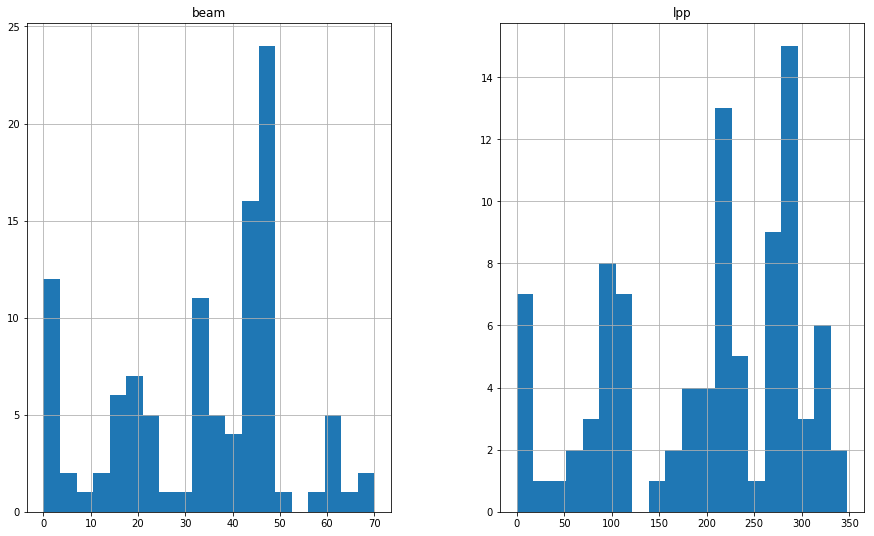

In [205]:
df_ships.hist(bins=20)

In [44]:
roll_decay_test = roll_decay_tests[0]

In [45]:
tables = ['min','mean','max','std']
statistics = {}
for table in tables:
    statistics[table] = pd.read_sql_table(table_name=table, con=engine)

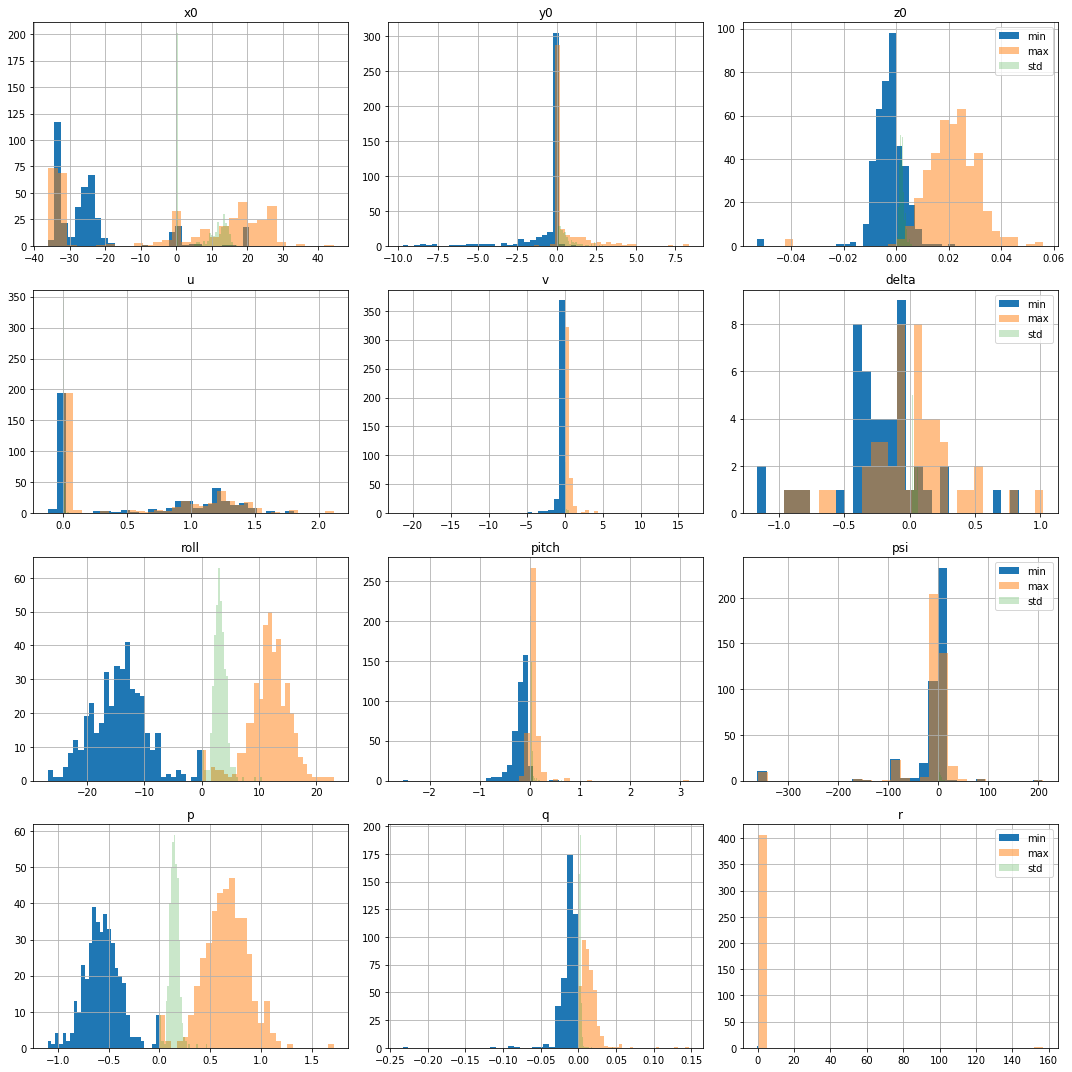

In [90]:
plots = [['x0','y0','z0'],
         ['u','v','delta'],
         ['roll','pitch','psi'],
         ['p','q','r']]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        min = statistics['min']
        max = statistics['max']
        std = statistics['std']
        
        bins = 30
        min[plot].hist(label='min', bins=bins, ax=ax)
        max[plot].hist(label='max', bins=bins, ax=ax, alpha=0.5)
        std[plot].hist(label='std', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

In [97]:
cols = ['roll','psi','u','r']
min[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,-14.354498,-17.665514,0.550688,-0.018214
std,4.852812,61.347784,0.603502,0.011007
min,-26.860000,-361.619797,-0.122843,-0.067245
25%,-17.305000,-4.765744,-0.013846,-0.023998
50%,-14.160000,-0.719400,0.279571,-0.016032
75%,-11.415000,-0.032600,1.174762,-0.009942
max,0.005000,207.702791,2.018690,-0.002182


In [98]:
max[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,11.733146,-10.616949,0.594980,0.406797
std,3.665115,60.102102,0.613089,7.785212
min,0.000900,-360.046997,0.002522,0.002182
25%,9.965000,-0.057686,0.012196,0.010908
50%,11.980000,0.734857,0.301464,0.017964
75%,14.070000,2.925701,1.216718,0.028362
max,23.000000,210.517791,2.117975,157.081401


In [100]:
std[cols].describe()

,roll,psi,u,r
count,406.000000,407.000000,407.000000,407.000000
mean,3.098627,1.740753,0.006957,0.012714
std,1.154276,2.450445,0.013807,0.153974
min,0.000191,0.002432,0.000956,0.000230
25%,2.433426,0.250915,0.002915,0.002489
50%,3.031317,0.656507,0.004814,0.004314
75%,3.732001,2.077588,0.007300,0.006954
max,10.478363,13.044742,0.232787,3.110646
